In [182]:
import matplotlib.pyplot as plt
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from matplotlib.patches import Circle
from astropy import units as u
from matplotlib.colors import LogNorm
import matplotlib.animation

In [153]:
def getImage(path):
  filename = get_pkg_data_filename(path)
  hdu = fits.open(filename)
  
  image_data = hdu[0].data
  image_header = hdu[0].header

  return image_data, image_header

In [154]:
def plotHist(image_data, nbins=200):
  # flatten means: we put our 2d array in a 1d array
  histogram = plt.hist(image_data.flatten(), nbins)

  plt.xlabel('Pixel Content')
  plt.ylabel('Number of Pixels')
  plt.yscale('log')
  plt.show()

In [179]:
def plotImage(image_header, image_data):
  fig = plt.figure()

  wcs = WCS(image_header)
  ax = WCSAxes(fig, [0, 0, 1, 1], wcs=wcs)
  fig.add_axes(ax)

  # Now with an other colormap and in logscale
  img = ax.imshow(image_data, cmap='afmhot', norm=LogNorm())

  ax.set_xlabel('RA')
  ax.set_ylabel('Dec')

  ax.grid(color='white', ls='solid')

  # Set the limits of the colorbar and a label
  cb = fig.colorbar(img)
  # img.set_clim(1.1*np.min(image_data), np.max(image_data))
  cb.set_label('Counts')

  plt.show()

In [156]:
def subtractImages(NB_image_data, BB_image_data, scale_factor):
  subtracted_arr = BB_image_data * scale_factor
  return np.subtract(NB_image_data, subtracted_arr)

In [157]:
R_data, R_header = getImage('data/rim_Ha_wcs.fits')
Ha_data, Ha_header = getImage('data/rim_R_wcs.fits')
SII_data, SII_header = getImage('data/rim_[SII]_wcs.fits')

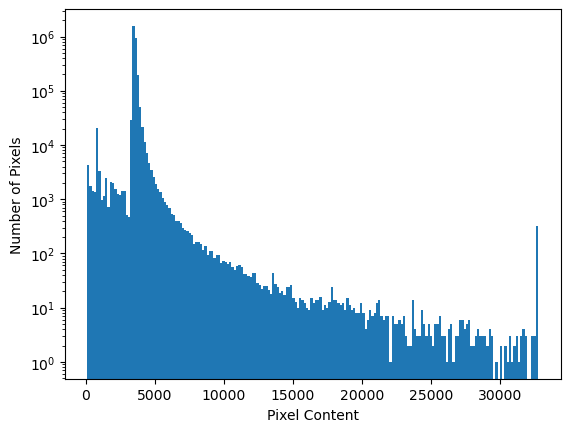

/home/joe/anaconda3/envs/pracs/lib/python3.11/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 59846.552361 from DATE-OBS'.
  warnings.warn(


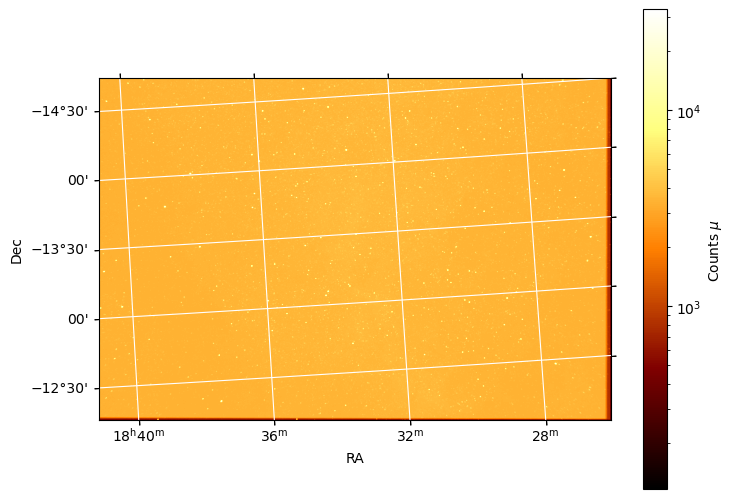

In [176]:
plotHist(R_data)
plotImage(R_header, R_data)

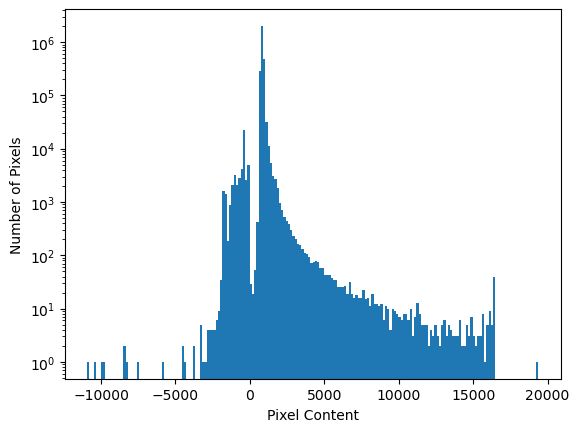

/home/joe/anaconda3/envs/pracs/lib/python3.11/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 59846.552361 from DATE-OBS'.
  warnings.warn(


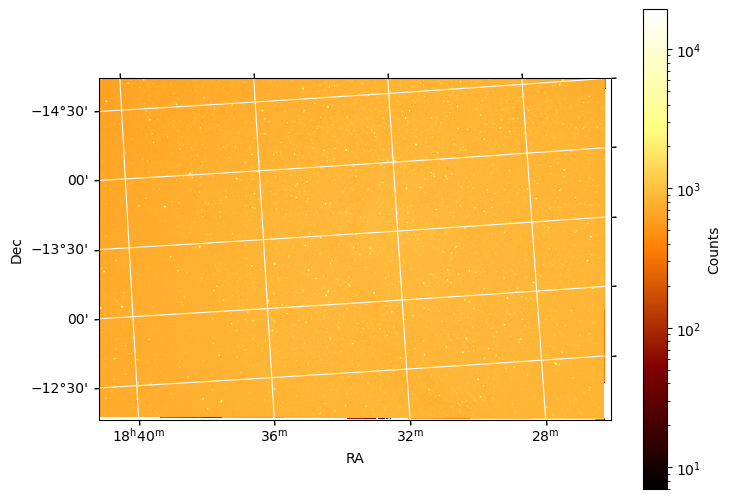

In [184]:
difference_image_data = subtractImages(Ha_data, R_data, 0.5)
plotHist(difference_image_data)
plotImage(R_header, difference_image_data)

In [284]:
plt.close('all')
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
    plt.cla()
    scale_factor = 0.5 + t*0.025
    # Now with an other colormap and in logscale
    img = ax.imshow(
        Ha_data - scale_factor*R_data, cmap='afmhot', 
        # vmin=np.min(Ha_data - R_data), vmax=np.max(Ha_data), 
        # vmin=-30000, vmax=30000, 
        norm=LogNorm(vmin=1, vmax=np.max(Ha_data))
    )
    plt.text(0, -10, f"mu = {scale_factor}")
    if t == 1: fig.colorbar(img)

matplotlib.animation.FuncAnimation(fig, animate, frames=25)

In [223]:
def calculateSkew(image_data):
  data = np.array(image_data.flatten())
  N = len(data)
  mean = np.mean(data)   # Mean of the data
  std_dev = np.std(data, ddof=1)
  
  # Compute skewness
  return np.sum(((data - mean) / std_dev) ** 3) / (N - 1)

In [226]:
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
  plt.cla()
  # Now with an other colormap and in logscale
  plt.hist((Ha_data - t*0.1*R_data).flatten(), nbins)
  plt.text(0, 1, f"mu = {round(t*0.1, 2)}", ha='left', va='top', transform=ax.transAxes)
  plt.text(0.2, 1, f"skew = {round(calculateSkew(Ha_data - t*0.1*R_data), 2)}", ha='left', va='top', transform=ax.transAxes)
  plt.yscale('log')

matplotlib.animation.FuncAnimation(fig, animate, frames=20)

In [239]:
def getSkews(NB_image_data, BB_image_data, scale_factor_linspace):
  skews = []
  for mu in scale_factor_linspace:
    skews.append(calculateSkew(NB_image_data - mu*BB_image_data))
  return skews

In [242]:
scale_factors = np.linspace(0, 2, 100)
Ha_R_skews = getSkews(Ha_data, R_data, np.linspace(0, 2, 100))

[15.332704510908664, 15.231905957085115, 15.126280367995816, 15.015439536168055, 14.899014595426681, 14.776538591587434, 14.647547333508557, 14.511550381144446, 14.367895656462636, 14.215976671632085, 14.055037734526184, 13.884277562816909, 13.702765011178235, 13.509469464753765, 13.303215248955311, 13.08268301098413, 12.846372418757053, 12.592577293523878, 12.319291666422023, 12.02432582626196, 11.70505626418002, 11.358519617083754, 10.981235142170625, 10.569265503863251, 10.117991585844795, 9.622080716070098, 9.07536371137396, 8.470800339439773, 7.800310082445734, 7.054745197400392, 6.223961864487271, 5.296879937859174, 4.2618179645425665, 3.107064443476612, 1.8217630352574585, 0.397199535532554, -1.17140957304431, -2.882859603938579, -4.7277577668261515, -6.686674087738343, -8.729129617432587, -10.814328724002792, -12.893581763090518, -14.91452907912283, -16.82666225500879, -18.586533828792906, -20.161925343282128, -21.53388094533355, -22.696617586972806, -23.65589621183418, -24.425

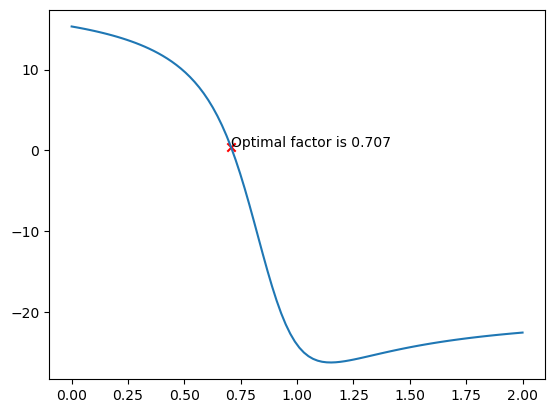

In [292]:
def find_nearest_zero(array, l=0, b=None):
    if b is None:
        b = len(array)
    
    # Base case: If there is one element left, return its index
    if b - l == 1:
        return l
    
    # Find the midpoint of the current range
    mid = (l + b) // 2

    # Check the midpoint value
    if array[mid] == 0:
        return mid  # Found exact zero
    elif array[mid] > 0:
        # Look in the lower half (towards smaller absolute values)
        return find_nearest_zero(array, l=mid, b=b)
    else:
        # Look in the upper half (towards smaller absolute values)
        return find_nearest_zero(array, l=l, b=mid)

plt.close('all')
plt.plot(scale_factors, Ha_R_skews)
pt = [scale_factors[find_nearest_zero(Ha_R_skews)], Ha_R_skews[find_nearest_zero(Ha_R_skews)]]
plt.scatter(pt[0], pt[1], c='r', marker='x')
plt.text(pt[0], pt[1], f'Optimal factor is {round(pt[0], 3)}')
print(Ha_R_skews)
plt.show()